In [40]:
from jpeg_implementation.dct import block_dct2, block_idct2
from jpeg_implementation.huffman import generate_huffman_code, encode_huffman, decode_huffman
from jpeg_implementation.quantization import quantize, quantize_inverse, \
    get_quantization_matrix_for_quality_percent
from jpeg_implementation.rgbToYuv import rgb_to_yuv, yuv_to_rgb
from jpeg_implementation.runLengthEncode import resort_and_run_length_encode, unsort_and_run_length_decode
from jpeg_implementation.splitBlocks import split, merge_blocks
from jpeg_implementation.subsample import subsample_u_v, calculate_down_sampled_resolution, up_sample_u_v
from jpeg_implementation.serialize import store_as_file
from jpeg_implementation.EasyJpeg import EasyJpeg

import os.path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from typing import Tuple

In [41]:
def plot_y_u_v(y_loc, u_loc, v_loc, colormap=True):
    fig_loc, ax_loc = plt.subplots(1, 3, figsize=(15, 20))
    ax_loc[0].imshow(y_loc, cmap="gray")
    ax_loc[0].set_title("Y Component")

    # creating a linear colormap, based on the values of the example https://commons.wikimedia.org/wiki/File:Barn-yuv.png
    if colormap:
        cmap_u = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0, 177 / 255, 78 / 255, 1),
                                                                          (0, 86 / 255, 169 / 255, 1)])
    else:
        cmap_u = matplotlib.colormaps["gray"]
    ax_loc[1].imshow(u_loc, cmap=cmap_u)
    ax_loc[1].set_title("U Component")

    if colormap:
        cmap_v = matplotlib.colors.LinearSegmentedColormap.from_list("", [(104 / 255, 151 / 255, 0, 1),
                                                                          (171 / 255, 84 / 255, 0)])
    else:
        cmap_v = matplotlib.colormaps["gray"]
    ax_loc[2].imshow(v_loc, cmap=cmap_v)
    ax_loc[2].set_title("V Component")
    plt.show()

In [42]:
images = {
    "christmas_tree_6000x4000": "images/christmas_tree_6000x4000.png",
    "christmas_tree_600x400": "images/christmas_tree_600x400.png",
    "christmas_tree_194x129": "images/christmas_tree_194x129.png",
    "Barns_grand_tetons_1600x1195": "images/Barns_grand_tetons_1600x1195.png",
    "lenna_512x512": "images/lenna_512x512.png",
    "lenna_256x256": "images/lenna_256x256.png",
    "lenna_128x128": "images/lenna_128x128.png",
    "lenna_64x64": "images/lenna_64x64.png",
    "lenna_32x32": "images/lenna_32x32.png",
}

In [43]:
# image which should be encoded
image_path = images["lenna_512x512"]

# jpeg parameters
block_size: int = 8
subsampling_settings: Tuple[int, int, int] = (4, 2, 0)  # can be (4,1,0), (4,1,1), (4,2,0), (4,2,2), (4,4,4)
quantization_table_quality: int = 10  # percentage of quantization quality 0..100

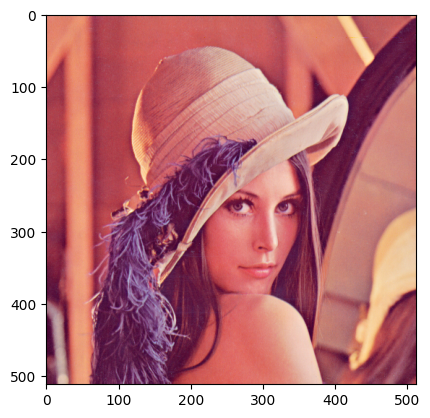

In [44]:
original_image = plt.imread(image_path)

# convert range from 0..1 to int (0..255)
original_image *= 255
original_image = np.rint(original_image)
original_image = original_image.astype(int)

# strip alpha channel if exists
if original_image.shape[2] == 4:
    channels = np.dsplit(original_image, 4)
    original_image = np.dstack(channels[:3])

original_image_resolution = tuple(reversed(original_image.shape[:2]))

fig, ax = plt.subplots()
ax.imshow(original_image)

## Step 1
### Colorspace Transformation

In [45]:
y, u, v = rgb_to_yuv(image=original_image)

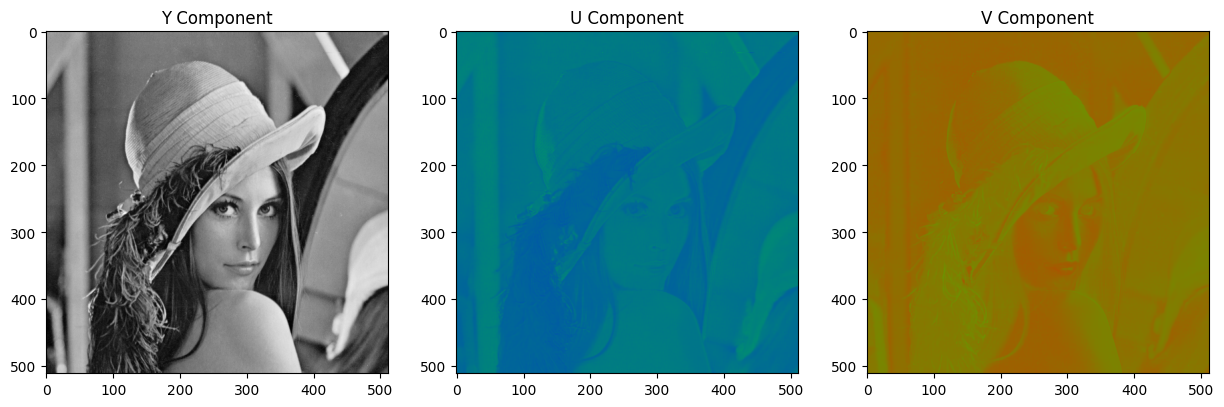

In [46]:
plot_y_u_v(y, u, v)

## Step 2
### Subsampling of Color Components

In [47]:
u_subs, v_subs = subsample_u_v(u, v, *subsampling_settings)

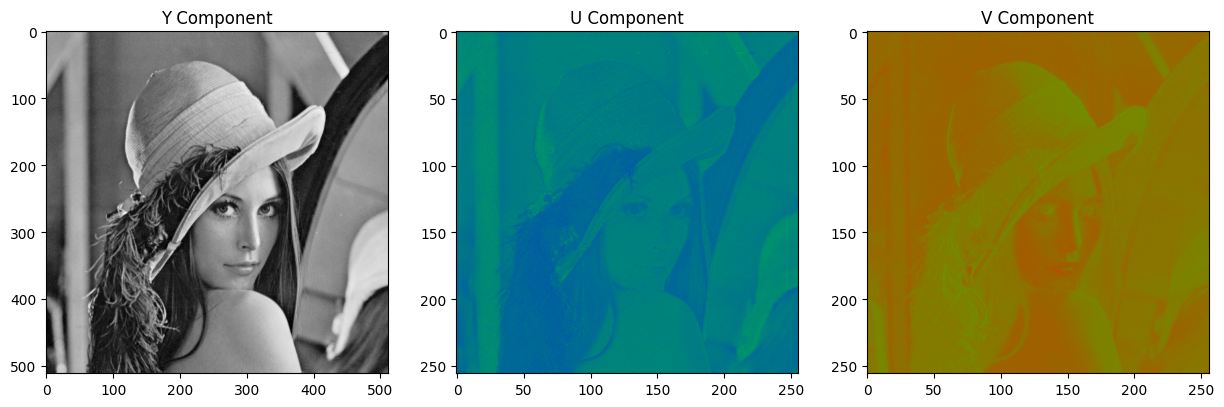

In [48]:
plot_y_u_v(y, u_subs, v_subs)

## Step 3
### Split into 8x8 Blocks

In [49]:
split_y = split(y, block_size)
split_u = split(u_subs, block_size)
split_v = split(v_subs, block_size)

## Step 4
### Apply dct

In [50]:
trans_y = block_dct2(np.array(split_y) - 128, block_size)
trans_u = block_dct2(np.array(split_u) - 128, block_size)
trans_v = block_dct2(np.array(split_v) - 128, block_size)

## Step 5
### Quantization


In [51]:
quantization_table = get_quantization_matrix_for_quality_percent(quantization_table_quality)

quantized_y = quantize(trans_y, quantization_table)
quantized_u = quantize(trans_u, quantization_table)
quantized_v = quantize(trans_v, quantization_table)

## Step 6
### Reordering of values, Run Length Encoding

In [52]:
rl_encoded_y = resort_and_run_length_encode(quantized_y, block_size)
rl_encoded_u = resort_and_run_length_encode(quantized_u, block_size)
rl_encoded_v = resort_and_run_length_encode(quantized_v, block_size)

## Step 7
### Huffman Encoding

In [54]:
huffman_code_y = generate_huffman_code(rl_encoded_y)
huff_encoded_y = encode_huffman(huffman_code_y, rl_encoded_y)

huffman_code_u = generate_huffman_code(rl_encoded_u)
huff_encoded_u = encode_huffman(huffman_code_u, rl_encoded_u)

huffman_code_v = generate_huffman_code(rl_encoded_v)
huff_encoded_v = encode_huffman(huffman_code_v, rl_encoded_v)

In [55]:
print("y", len(huff_encoded_y), "bits")
print("u", len(huff_encoded_u), "bits")
print("v", len(huff_encoded_v), "bits")
print("encoded", len(huff_encoded_y) + len(huff_encoded_u) + len(huff_encoded_v), "bits")
data = rl_encoded_y + rl_encoded_u + rl_encoded_v
print("compression ratio", len(data * 8) / (len(huff_encoded_y) + len(huff_encoded_u) + len(huff_encoded_v)))

y 104872 bits
u 12718 bits
v 17070 bits
encoded 134660 bits
compression ratio 2.52143175404723


## Step 8
### Serialization

In [56]:
file_size = store_as_file("test2.data", huffman_code_y, huffman_code_u, huffman_code_v, huff_encoded_y, huff_encoded_u,
                          huff_encoded_v, quantization_table, *subsampling_settings, *original_image_resolution)


In [57]:
original_size = os.path.getsize(image_path)
compression_ratio = original_size / file_size
print("Effective Compression Ratio:", compression_ratio, "(Compared to PNG file)")

Effective Compression Ratio: 26.24375519246746 (Compared to PNG file)


## Step 9
### Deserialization

In [58]:
from jpeg_implementation.serialize import read_from_file

huffman_code_y, huffman_code_u, huffman_code_v, huff_encoded_y, huff_encoded_u, huff_encoded_v, quantization_table, j,a,b,x_dim,y_dim = read_from_file(
    "test2.data")


## Step 10
### Decode Huffman

In [59]:
rl_encoded_y = decode_huffman(huff_encoded_y, huffman_code_y)
rl_encoded_u = decode_huffman(huff_encoded_u, huffman_code_u)
rl_encoded_v = decode_huffman(huff_encoded_v, huffman_code_v)

## Step 11
### Decode run-length encoding + Reordering of values

In [60]:
y_blocks = unsort_and_run_length_decode(rl_encoded_y, block_size)
u_blocks = unsort_and_run_length_decode(rl_encoded_u, block_size)
v_blocks = unsort_and_run_length_decode(rl_encoded_v, block_size)

## Step 12
### Apply inverse quantization

In [61]:
iq_y = quantize_inverse(y_blocks, quantization_table)
iq_u = quantize_inverse(u_blocks, quantization_table)
iq_v = quantize_inverse(v_blocks, quantization_table)

## Step 13
### Apply inverse DCT

In [62]:
id_y = block_idct2(iq_y, block_size) + 128
id_u = block_idct2(iq_u, block_size) + 128
id_v = block_idct2(iq_v, block_size) + 128

## Step 14
### Merge Blocks

In [63]:
downsampled_resolution = calculate_down_sampled_resolution(j,a,b, (x_dim, y_dim))
compressed_y = merge_blocks(id_y, (x_dim, y_dim), block_size)
compressed_u = merge_blocks(id_u, downsampled_resolution, block_size)
compressed_v = merge_blocks(id_v, downsampled_resolution, block_size)

## Step 15
### Upsample

In [64]:
compressed_u, compressed_v = up_sample_u_v(compressed_u,compressed_v, j,a,b, (x_dim, y_dim))

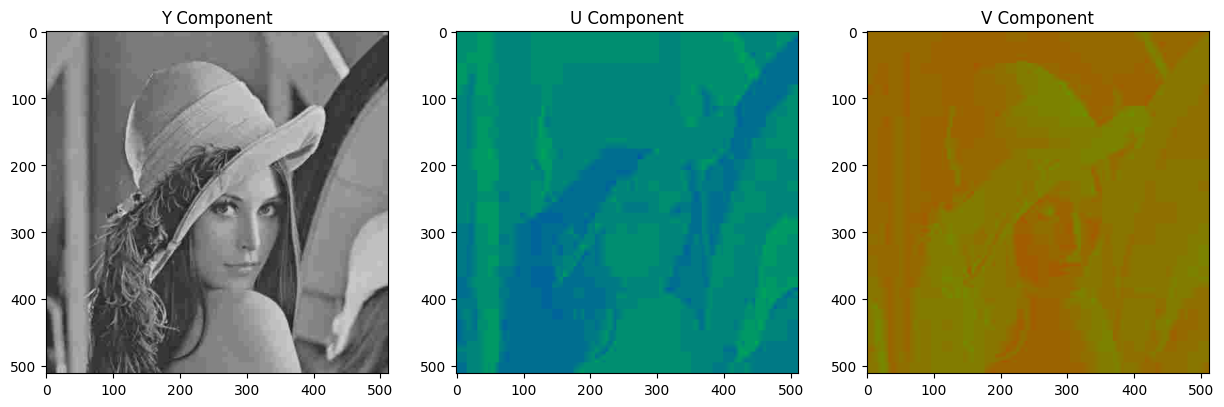

In [65]:
plot_y_u_v(compressed_y,compressed_u,compressed_v)

## Step 16
### Inverse Colorspace Transformation

In [66]:
reconstructed_image = yuv_to_rgb(compressed_y,compressed_u, compressed_v)

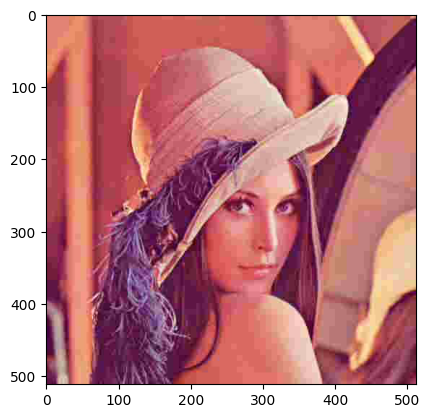

In [67]:
fig, ax = plt.subplots()
ax.imshow(reconstructed_image)
plt.show()

# Evaluation

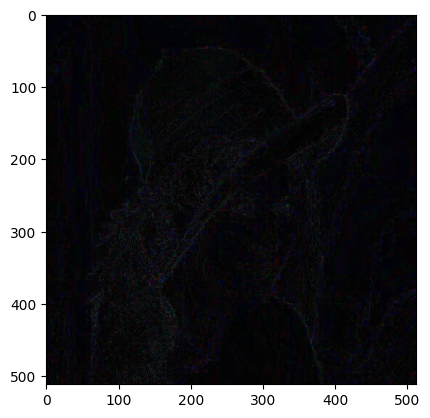

In [68]:
diff = np.abs(original_image - reconstructed_image)

fig, ax = plt.subplots()
ax.imshow(diff)
plt.show()

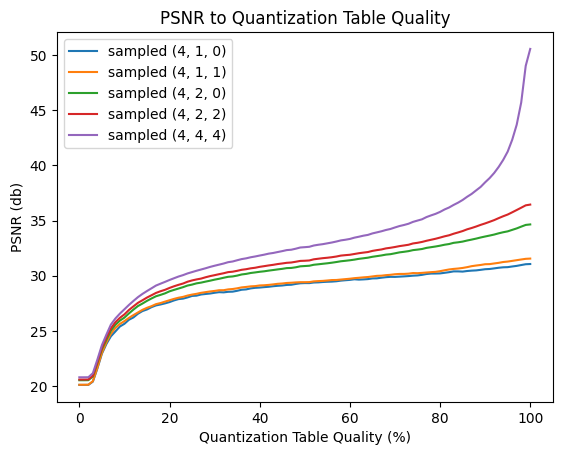

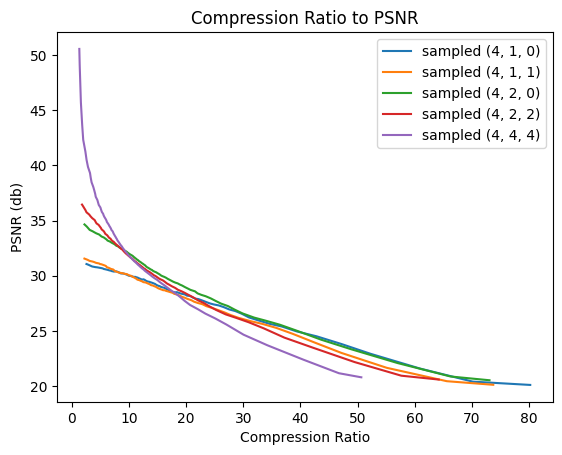

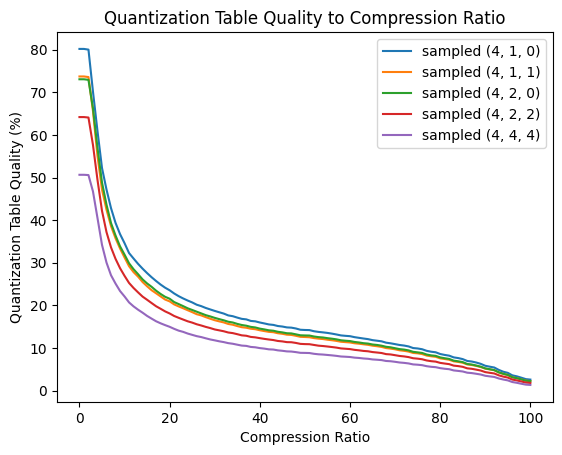

In [39]:
image_path = images["lenna_256x256"]
# image_path = images["lenna_32x32"]

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

subsampling_settings_list = [(4,1,0), (4,1,1), (4,2,0), (4,2,2), (4,4,4)]

for s in subsampling_settings_list:
    quality_settings = list(range(101))
    psnr_values = []
    compression_ratios = []
    for i in quality_settings:
        jpeg = EasyJpeg.from_png(image_path, i, s, 8)
        psnr = jpeg.get_psnr()
        compression_ratio = jpeg.get_compression_ratio()
        psnr_values.append(psnr)
        compression_ratios.append(compression_ratio)

    ax1.plot(quality_settings, psnr_values, label=f"sampled {str(s)}")
    ax2.plot(compression_ratios, psnr_values, label=f"sampled {str(s)}")
    ax3.plot(quality_settings, compression_ratios, label=f"sampled {str(s)}")

ax1.set_title(f"PSNR to Quantization Table Quality")
ax1.set_xlabel("Quantization Table Quality (%)")
ax1.set_ylabel("PSNR (db)")
ax1.legend()

ax2.set_title(f"Compression Ratio to PSNR")
ax2.set_xlabel("Compression Ratio")
ax2.set_ylabel("PSNR (db)")
ax2.legend()

ax3.set_title(f"Quantization Table Quality to Compression Ratio")
ax3.set_xlabel("Compression Ratio")
ax3.set_ylabel("Quantization Table Quality (%)")
ax3.legend()

plt.show()